Cell 1: Environment Setup,Logging & Data Loading

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from scipy.stats import poisson

# --- LOGGING SETUP ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_dataset(path):
    """Loads the cleaned dataset and sets PatientID as index."""
    try:
        data = pd.read_csv(path, index_col='PatientID')
        logger.info(f"Successfully loaded data. Shape: {data.shape}")
        return data
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None

# Execution
path = '../data/parkinsons_cleaned.csv'
df = load_dataset(path)

2026-01-13 17:34:28,682 - INFO - Successfully loaded data. Shape: (2105, 33)


Cell 2: Global Correlation Heatmap

2026-01-13 17:36:05,364 - INFO - Generating global correlation heatmap.


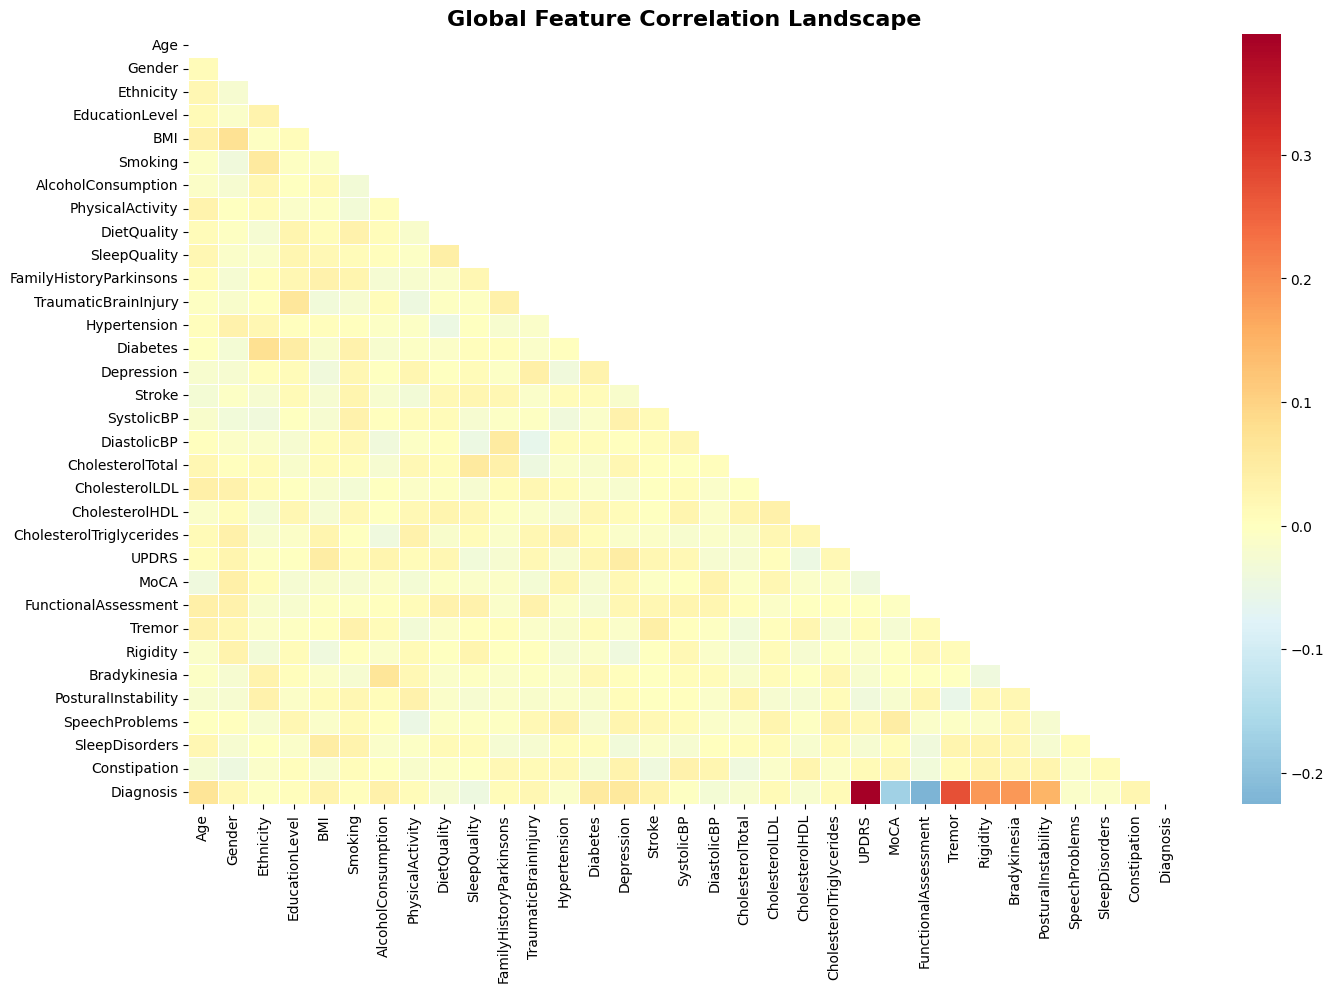

In [9]:
def plot_global_heatmap(data):
    """Generates a professional heatmap for the entire feature set."""
    logger.info("Generating global correlation heatmap.")
    corr_matrix = data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_matrix, mask=mask, cmap='RdYlBu_r', center=0, linewidths=0.5)
    plt.title('Global Feature Correlation Landscape', fontsize=16, fontweight='bold')
    plt.show()

# Execution
if df is not None:
    plot_global_heatmap(df)

Cell 3: Risk/Protective Factors vs. Clinical Symptoms

2026-01-13 17:37:54,401 - INFO - Visualizing risk factors vs. clinical symptoms.


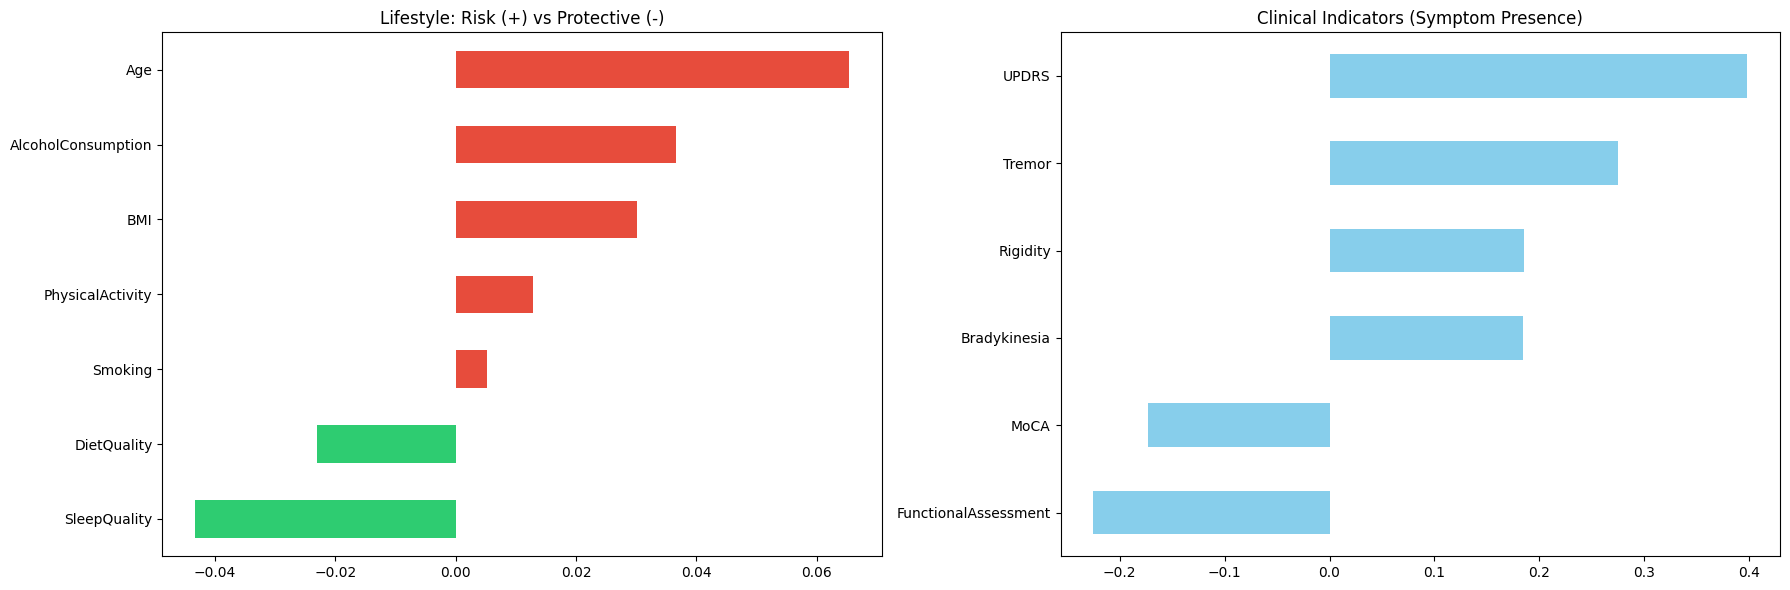

In [10]:
def plot_diagnosis_correlations(data):
    """Separates lifestyle predictors from symptoms in relation to Diagnosis."""
    logger.info("Visualizing risk factors vs. clinical symptoms.")
    corr = data.corr()['Diagnosis']
    
    lifestyle = ['Age', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality']
    clinical = ['UPDRS', 'MoCA', 'FunctionalAssessment', 'Tremor', 'Rigidity', 'Bradykinesia']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Lifestyle
    ls_data = corr[lifestyle].sort_values()
    ls_data.plot(kind='barh', color=['#2ecc71' if x < 0 else '#e74c3c' for x in ls_data], ax=ax1)
    ax1.set_title('Lifestyle: Risk (+) vs Protective (-)')
    
    # Plot Symptoms
    corr[clinical].sort_values().plot(kind='barh', color='skyblue', ax=ax2)
    ax2.set_title('Clinical Indicators (Symptom Presence)')
    
    plt.tight_layout()
    plt.show()

# Execution
plot_diagnosis_correlations(df)

Cell 4: Defining the Sick Population for Progression Analysis

In [4]:
def extract_sick_population(data):
    """
    Filters the dataset to include only patients diagnosed with Parkinson's.
    """
    sick_subset = data[data['Diagnosis'] == 1].copy()
    logger.info(f"Population filtered. Analyzing {len(sick_subset)} diagnosed patients.")
    return sick_subset

# --- EXECUTION ---
if df is not None:
    sick_df = extract_sick_population(df)

2026-01-13 17:19:07,010 - INFO - Population filtered. Analyzing 1304 diagnosed patients.


Cell 5: Comparing the Three Severity Metrics

2026-01-13 17:40:27,249 - INFO - Comparing distributions of UPDRS, MoCA, and Functional Assessment.


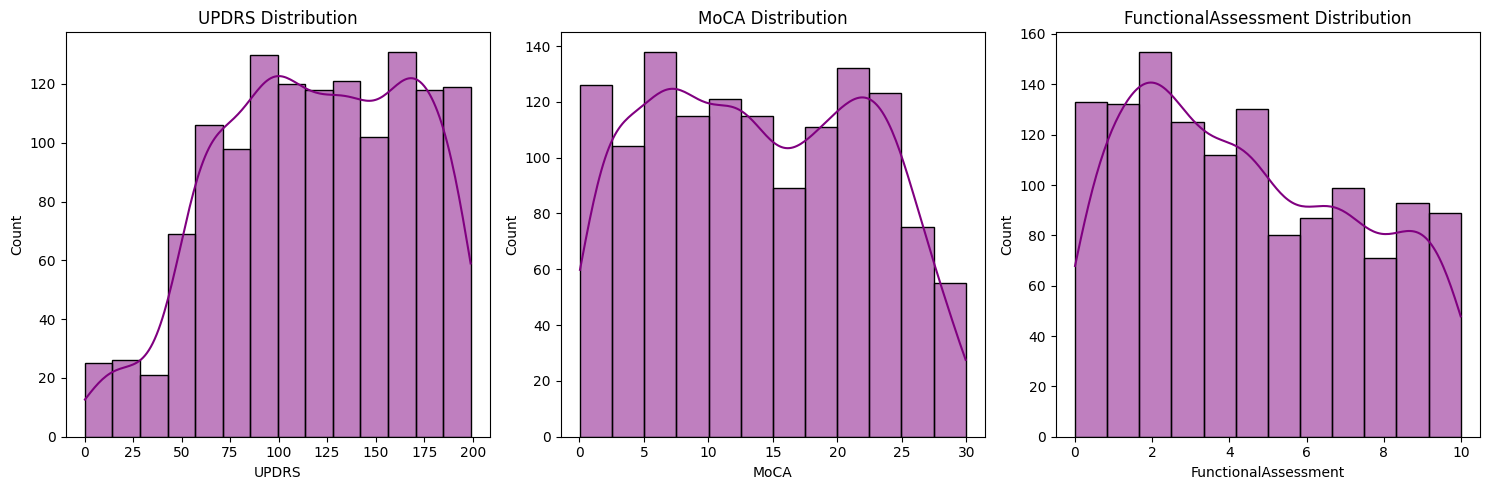

In [11]:
def plot_severity_distributions(data):
    """Visualizes the distribution and scale of the three primary severity metrics."""
    logger.info("Comparing distributions of UPDRS, MoCA, and Functional Assessment.")
    metrics = ['UPDRS', 'MoCA', 'FunctionalAssessment']
    
    plt.figure(figsize=(15, 5))
    for i, m in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(data[m], kde=True, color='purple')
        plt.title(f'{m} Distribution')
    plt.tight_layout()
    plt.show()

# Execution
plot_severity_distributions(sick_df)

Cell 6: Metric Dissociation & Absolute Correlation Strength

2026-01-13 17:42:33,323 - INFO - Executing dissociation analysis with absolute correlations.


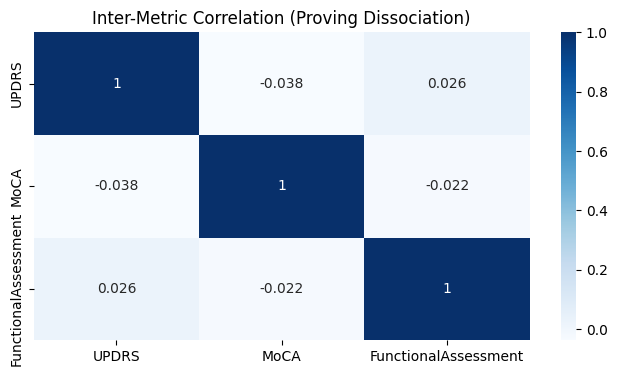

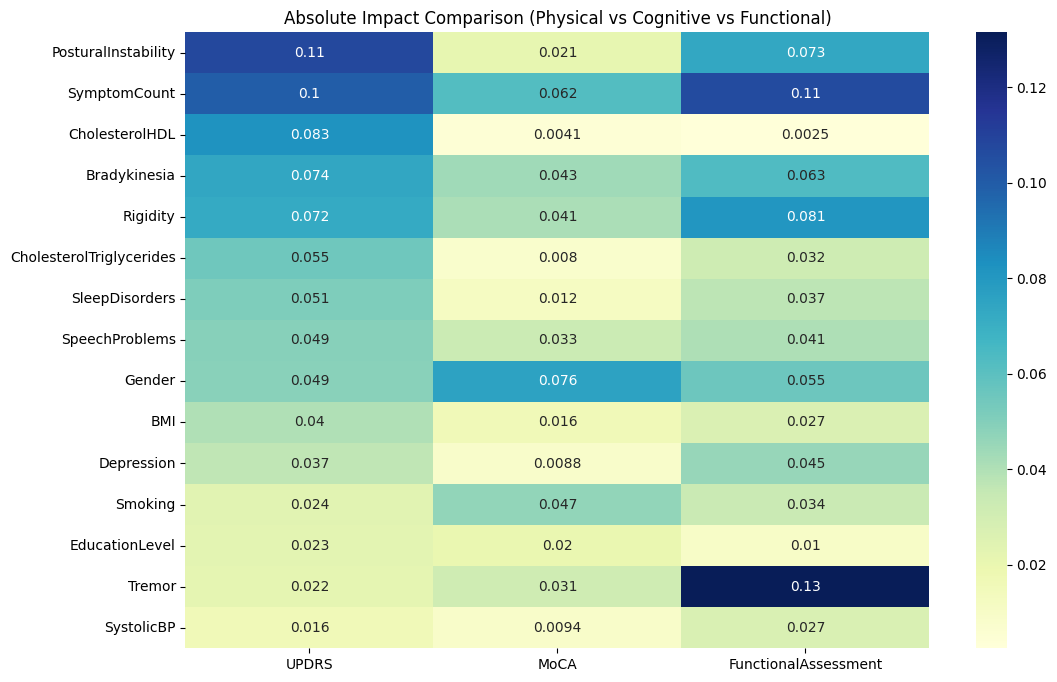

In [13]:
def analyze_metric_dissociation(data):
    """
    Analyzes the correlation strength (absolute) and proves metric dissociation.
    Ensures categorical strings are excluded from mathematical correlations.
    """
    logger.info("Executing dissociation analysis with absolute correlations.")
    metrics = ['UPDRS', 'MoCA', 'FunctionalAssessment']
    
    # 1. Prove metrics are not highly correlated with each other
    inter_corr = data[metrics].corr()
    plt.figure(figsize=(8, 4))
    sns.heatmap(inter_corr, annot=True, cmap='Blues')
    plt.title('Inter-Metric Correlation (Proving Dissociation)')
    plt.show()

    # 2. Filter for numeric features only to prevent ValueError
    # We exclude the metrics themselves and only keep numbers (float/int)
    numeric_data = data.select_dtypes(include=[np.number])
    features = [c for c in numeric_data.columns if c not in metrics and c != 'Diagnosis']
    
    # 3. Calculate absolute impact of features
    # .abs() is used because we care about strength of relationship, not direction
    comparison = pd.DataFrame({
        m: numeric_data[features + [m]].corr()[m].drop(m).abs() 
        for m in metrics
    })
    
    plt.figure(figsize=(12, 8))
    # Sorting by UPDRS to highlight the most physically impactful features
    sns.heatmap(comparison.sort_values(by='UPDRS', ascending=False).head(15), 
                annot=True, cmap='YlGnBu')
    plt.title('Absolute Impact Comparison (Physical vs Cognitive vs Functional)')
    plt.show()

# --- EXECUTION ---
if 'sick_df' in locals():
    analyze_metric_dissociation(sick_df)

Cell 7: Poisson Analysis 

2026-01-13 17:19:58,601 - INFO - Running Poisson Distribution analysis.


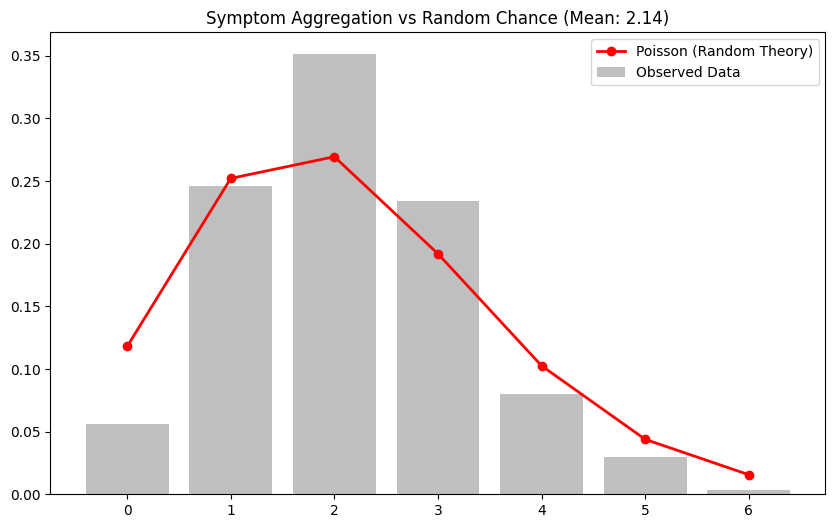

In [5]:
def run_poisson_analysis(data):
    """
    Compares actual symptom clustering against a random Poisson model.
    """
    logger.info("Running Poisson Distribution analysis.")
    symptom_list = ['Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 
                    'SpeechProblems', 'SleepDisorders', 'Constipation']
    
    data['SymptomCount'] = data[symptom_list].sum(axis=1)
    mu = data['SymptomCount'].mean()
    
    # Calculate distributions
    actual = data['SymptomCount'].value_counts(normalize=True).sort_index()
    theoretical = [poisson.pmf(k, mu) for k in range(len(actual))]
    
    plt.figure(figsize=(10, 6))
    plt.bar(actual.index, actual.values, alpha=0.5, label='Observed Data', color='grey')
    plt.plot(actual.index, theoretical, 'ro-', linewidth=2, label='Poisson (Random Theory)')
    plt.title(f'Symptom Aggregation vs Random Chance (Mean: {mu:.2f})')
    plt.legend()
    plt.show()

# --- EXECUTION ---
if 'sick_df' in locals():
    run_poisson_analysis(sick_df)

Gatekeeper Analysis: Impact of Specific Symptoms on Overall Disease Burden

2026-01-13 17:20:56,841 - INFO - Executing Gatekeeper Analysis (Tremor Paradox).
/tmp/ipykernel_475713/563220723.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impact_df, x='Impact', y='Symptom', palette=colors)


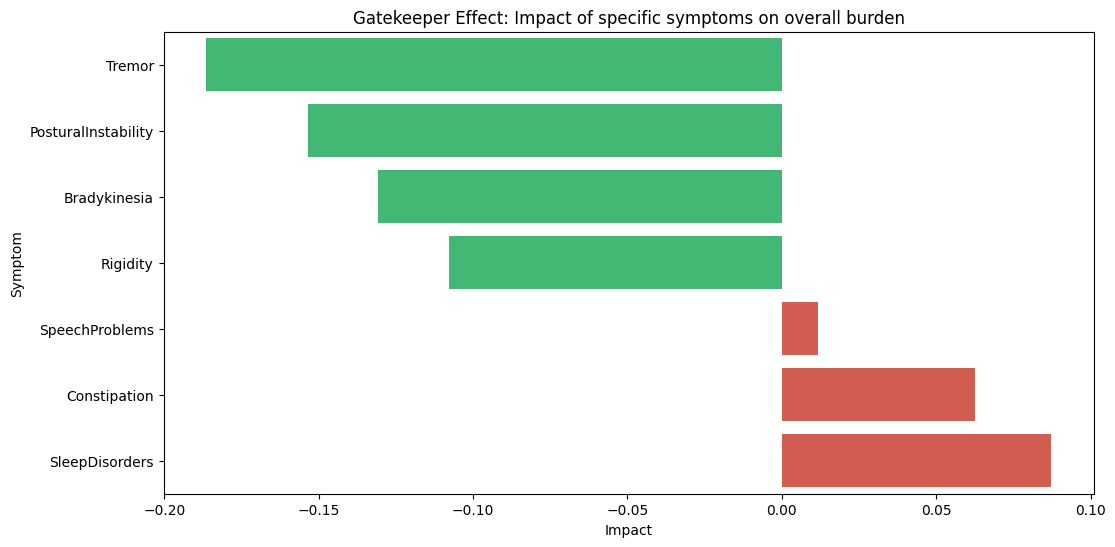

In [6]:
def run_gatekeeper_analysis(data):
    """
    Identifies which symptoms correlate with a higher or lower overall symptom burden.
    """
    logger.info("Executing Gatekeeper Analysis (Tremor Paradox).")
    symptoms = ['Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 
                'SpeechProblems', 'SleepDisorders', 'Constipation']
    results = []

    for s in symptoms:
        others = [sym for sym in symptoms if sym != s]
        impact = data[data[s] == 1][others].sum(axis=1).mean() - data[data[s] == 0][others].sum(axis=1).mean()
        results.append({'Symptom': s, 'Impact': impact})

    impact_df = pd.DataFrame(results).sort_values(by='Impact')
    
    plt.figure(figsize=(12, 6))
    colors = ['#2ecc71' if x < 0 else '#e74c3c' for x in impact_df['Impact']]
    sns.barplot(data=impact_df, x='Impact', y='Symptom', palette=colors)
    plt.title('Gatekeeper Effect: Impact of specific symptoms on overall burden')
    plt.show()

# --- EXECUTION ---
if 'sick_df' in locals():
    run_gatekeeper_analysis(sick_df)

Cell 9: Detailed Symptom Comparison (The Tremor Paradox)

2026-01-13 17:59:24,550 - INFO - Comparing symptom prevalence: Tremor vs. No-Tremor groups.


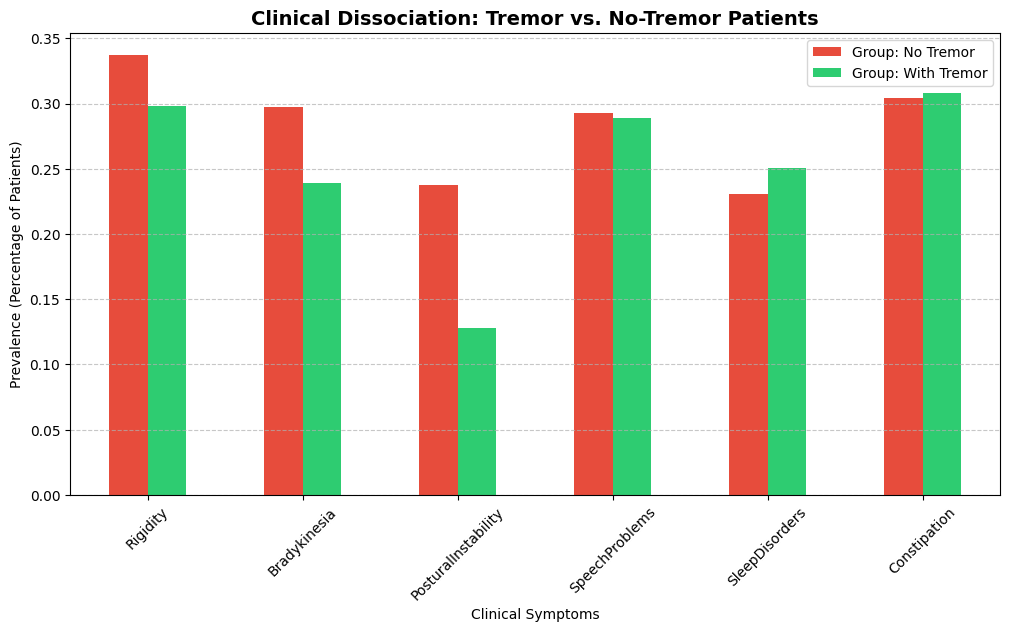

2026-01-13 17:59:24,871 - INFO - Tremor group comparison visualization complete.


In [16]:
def plot_tremor_comparison(data):
    """
    Compares the prevalence of non-tremor symptoms between two patient groups.
    This helps visualize why Tremor acts as a 'buffer' symptom.
    """
    logger.info("Comparing symptom prevalence: Tremor vs. No-Tremor groups.")
    
    # Define the symptoms to compare (excluding Tremor itself)
    other_symptoms = [
        'Rigidity', 'Bradykinesia', 'PosturalInstability', 
        'SpeechProblems', 'SleepDisorders', 'Constipation'
    ]
    
    # Calculate prevalence (%) for each group
    # Grouping by 'Tremor' and calculating the mean (prevalence)
    comparison_df = data.groupby('Tremor')[other_symptoms].mean().T
    comparison_df.columns = ['Group: No Tremor', 'Group: With Tremor']
    
    # Plotting
    comparison_df.plot(kind='bar', color=['#e74c3c', '#2ecc71'], figsize=(12, 6))
    
    plt.title('Clinical Dissociation: Tremor vs. No-Tremor Patients', fontsize=14, fontweight='bold')
    plt.ylabel('Prevalence (Percentage of Patients)')
    plt.xlabel('Clinical Symptoms')
    plt.xticks(rotation=45)
    plt.legend(frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- EXECUTION ---
# Using an 'if' check to ensure sick_df is available in memory
if 'sick_df' in locals():
    plot_tremor_comparison(sick_df)
    logger.info("Tremor group comparison visualization complete.")

Cell 10: The Disease Progression Roadmap

2026-01-13 18:02:02,464 - INFO - Generating the final disease progression roadmap.


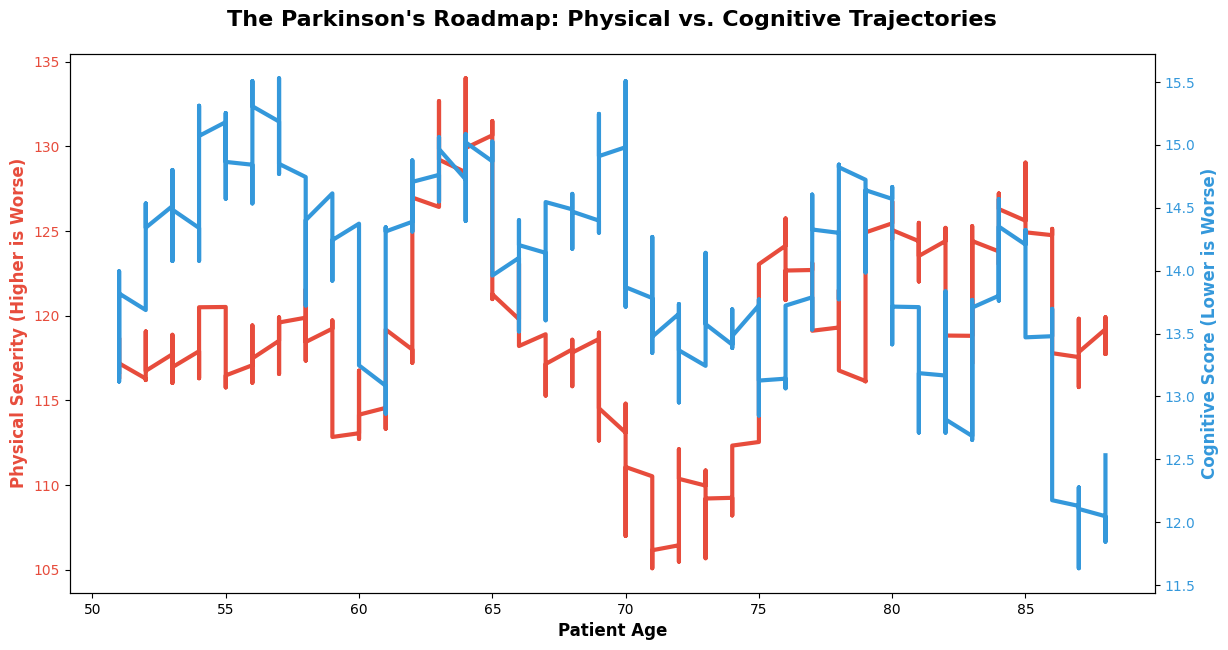

2026-01-13 18:02:02,829 - INFO - Analysis notebook execution finalized successfully.


In [ ]:
def plot_disease_roadmap(data):
    """
    Visualizes the physical vs. cognitive decline across the lifespan.
    Uses rolling averages to reveal the underlying progression trends.
    """
    logger.info("Generating the final disease progression roadmap.")
    
    # Sort by age to create a chronological timeline of disease evolution
    roadmap_df = data.sort_values('Age')
    
    # Apply a rolling window to smooth out individual patient noise
    # Window of 100 captures the general population trend
    roadmap_df['Physical_Trend'] = roadmap_df['UPDRS'].rolling(window=100, center=True).mean()
    roadmap_df['Cognitive_Trend'] = roadmap_df['MoCA'].rolling(window=100, center=True).mean()
    
    # Setup the dual-axis visualization
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot Physical Severity (UPDRS) - Red Axis
    ax1.plot(roadmap_df['Age'], roadmap_df['Physical_Trend'], color='#e74c3c', linewidth=3, label='Physical (UPDRS)')
    ax1.set_xlabel('Patient Age', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Physical Severity (Higher is Worse)', color='#e74c3c', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='#e74c3c')
    
    # Plot Cognitive Performance (MoCA) - Blue Axis
    ax2 = ax1.twinx()
    ax2.plot(roadmap_df['Age'], roadmap_df['Cognitive_Trend'], color='#3498db', linewidth=3, label='Cognitive (MoCA)')
    ax2.set_ylabel('Cognitive Score (Lower is Worse)', color='#3498db', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#3498db')
    
    plt.title('The Parkinson\'s Roadmap: Physical vs. Cognitive Trajectories', fontsize=16, fontweight='bold', pad=20)
    plt.show()
    logger.info("Analysis notebook execution finalized successfully.")

# --- EXECUTION ---
if 'sick_df' in locals():
    plot_disease_roadmap(sick_df)